# Problem Statement

An online retail store is trying to understand the customer purchase patterns from their sales. This project attempts to provide evidence-based insights to improve sales based on customers’ purchasing patterns.

The project, in particular, undertakes the following tasks:

1. Using historical data of customers’ purchases to generate useful insights that can be used to improve overall sales
2. Segment the customers based on their purchasing behaviour

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/e-commerce/OnlineRetail (3).csv


In [2]:
# Importing libraries

import re, random, time, itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, calendar

import datetime as dt
from datetime import datetime, timedelta
from mlxtend.frequent_patterns import apriori,association_rules
from collections import Counter
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

sns.set_palette('Set2')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('../input/e-commerce/OnlineRetail (3).csv', encoding = 'unicode_escape')
df = df.rename(columns=lambda x: re.sub('([a-z])([A-Z])', '\\1_\\2', x).lower())

In [4]:
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


We find that there are:

**Three quantitative features**: quantity, unit price, and customer id  
**Three descriptive features**: stock code, description, and country

For exploration, we can convert invoice number (currently a string) to a number value, and parse the invoice dates as standard datetime objects.  
We next check the number of unique entries for each feature.

In [6]:
unique_entries = pd.DataFrame(index=df.columns)
unique_entries.index.name = 'Feature'

for idx in unique_entries.index:
    
    unique_entries.loc[idx, 'Unique Entries'] = df[idx].nunique()
    
unique_entries

,Unique Entries
Feature,
invoice_no,25900.0
stock_code,4070.0
description,4223.0
quantity,722.0
invoice_date,23260.0
unit_price,1630.0
customer_id,4372.0
country,38.0


The above table shows that the data contains purchase records  

* from 38 countries, while 446 records have country details ‘Unspecified’  
* of 4372 unique customer ids transacting through 25900 invoices  
* of 4070 unique product ids  
* The records span a period from 1.12.2010 to 9.12.2011.

In [7]:
(100 * df.isnull().sum())/len(df)

Feature
invoice_no       0.000000
stock_code       0.000000
description      0.268311
quantity         0.000000
invoice_date     0.000000
unit_price       0.000000
customer_id     24.926694
country          0.000000
dtype: float64

A preliminary inspection shows that a high number of records (~25%) have a missing CustomerID field. The percentage being too high, we do not directly drop these records.  

However, we drop the 0.26% records with a missing ‘Description’ field, as Item Description is crucial to our
analysis. We also notice that some quantity values are negative. We drop these records from our analysis.

In [8]:
df = df.dropna(subset=['description'])
df = df[df.quantity > 0]

We notice that some stock codes have multiple description phrases. At present, we do not modify these.  
We look at aggregate summaries of quantitative features below.

In [9]:
df[['quantity', 'unit_price']].describe()

Feature,quantity,unit_price
count,530693.000000,530693.000000
mean,10.605819,3.861599
std,156.637853,41.833162
min,1.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


We find that there is significant variation in quantities of items purchased. 50% and 75% purchases across items involve low unit prices and quantities ordered. Yet, the maximum values of unit prices and quantities are very high.

Next, we parse our date column as a datetime object, extract information about month, day, hour, etc. and insert as additional columns.

In [10]:
df['invoice_date'] = pd.to_datetime(df.invoice_date, format='%m/%d/%Y %H:%M')
df.insert(loc=2, column='month_year', value=df.invoice_date.apply(lambda x: str(x.month)+'-'+ str(x.year)))
df.insert(loc=3, column='month', value=df.invoice_date.dt.month)

df.insert(loc=4, column='day', value=(df.invoice_date.dt.dayofweek)+1)
df.insert(loc=5, column='hour', value=df.invoice_date.dt.hour)

In [11]:
invoices = df['invoice_no'].unique()
stock_codes = df['stock_code'].unique()
descriptions = df['description'].unique()
customers = df['customer_id'].unique()

## Rule-based Recommendation Systems

As a first attempt, we can recommend items based on simple, common sensical business rules, e.g. popularity, etc. For example, we can recommend from a list of top 10 globally popular items, based on total quantities ordered.

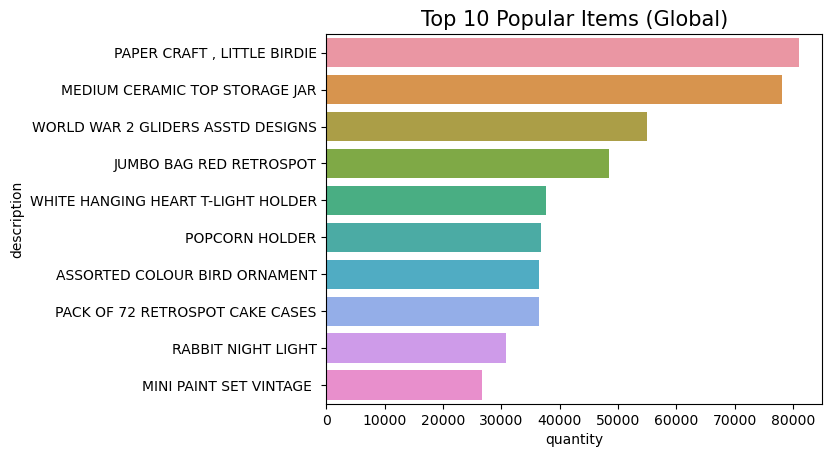

In [12]:
global_popularity = df.pivot_table(index=['stock_code', 'description'], values='quantity', aggfunc='sum').sort_values(by='quantity', ascending=False)
global_popularity.reset_index(inplace=True)
global_popularity.head(10)

sns.barplot(y='description', x='quantity', data=global_popularity.head(10))
plt.title('Top 10 Popular Items (Global)', fontsize=15)
plt.show()

We can also generate above lists for each country.

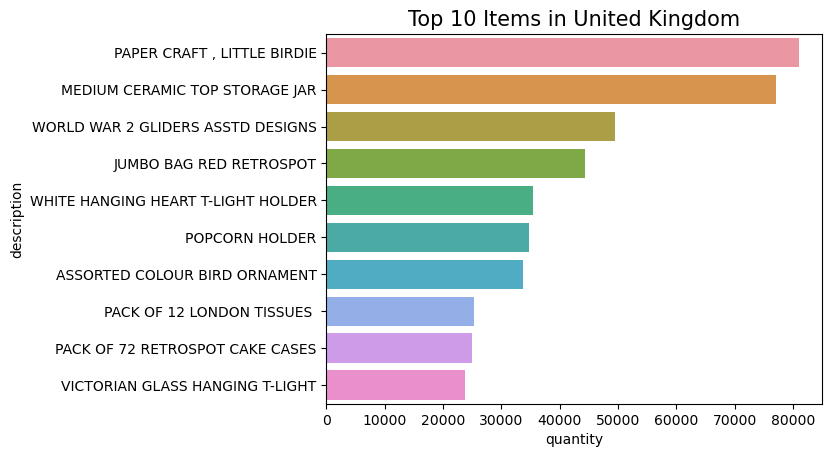

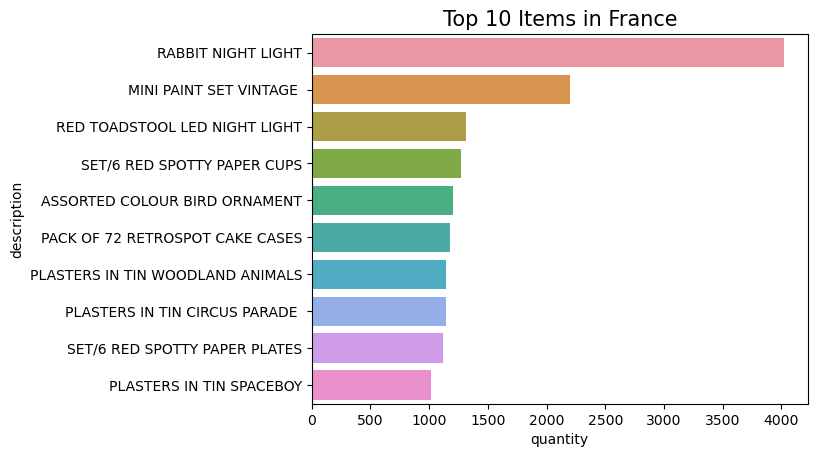

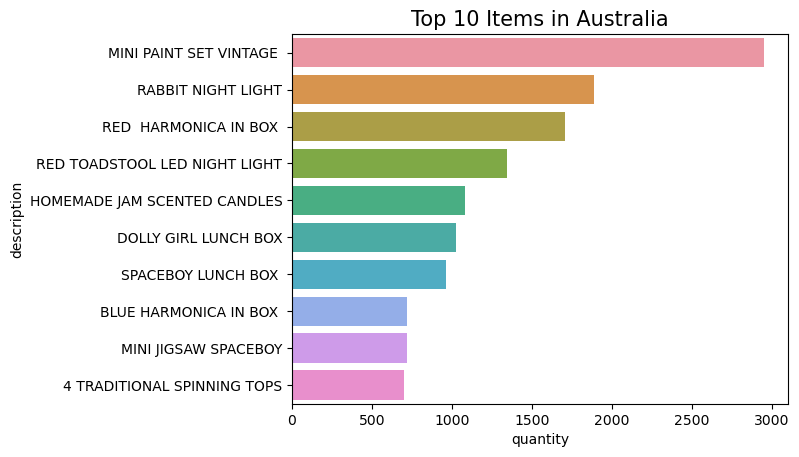

In [13]:
countrywise_popularity = df.pivot_table(index=['country', 'stock_code', 'description'], values='quantity', aggfunc='sum').reset_index()

for country in df['country'].unique()[:3]:
    
    sns.barplot(x='quantity', y='description', data=countrywise_popularity[ countrywise_popularity['country'] == country].sort_values(by='quantity', ascending=False).head(10))
    plt.title('Top 10 Items in '+country, fontsize=15)
    plt.show()

We can also generate the list of top 10 popular items for each month.

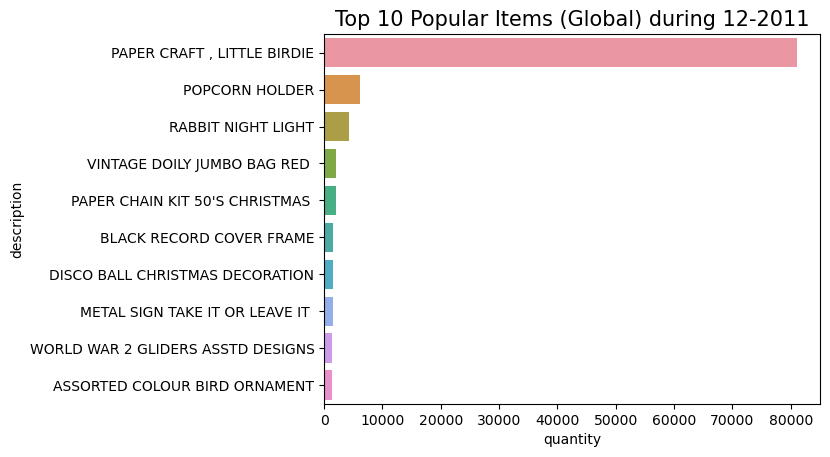

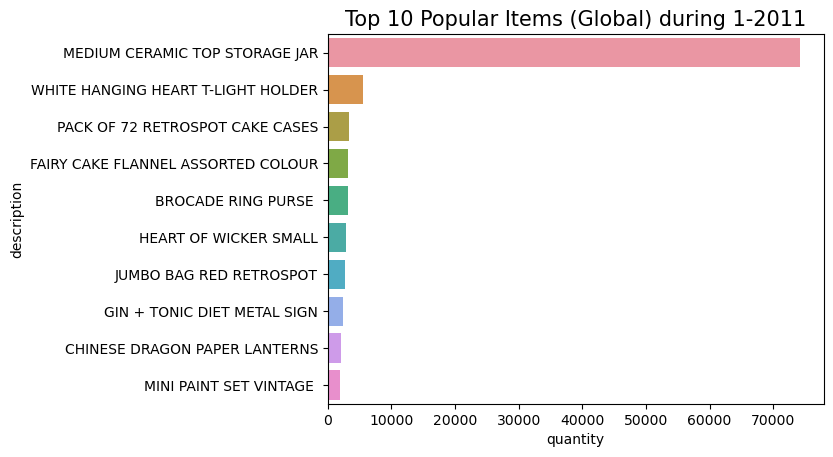

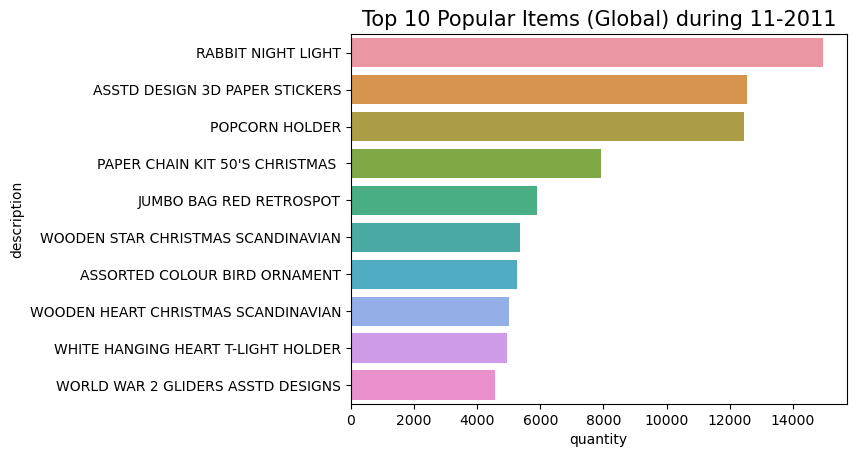

In [14]:
monthwise_popularity = df.pivot_table(index=['month_year', 'country', 'description'], values='quantity', aggfunc='sum').reset_index()

monthwise_global_popularity = monthwise_popularity.pivot_table(index=['month_year', 'description'], values='quantity', aggfunc='sum').sort_values(by='quantity', ascending=False)
monthwise_global_popularity = monthwise_global_popularity.reset_index()

for month in monthwise_global_popularity['month_year'].unique()[:3]:
    
    data = monthwise_global_popularity[monthwise_global_popularity.month_year==month].head(10)

    sns.barplot(y='description', x='quantity', data=data.head(10))
    plt.title('Top 10 Popular Items (Global) during ' + str(month), fontsize=15)
    plt.show()

We can also generate list of top 10 popular items for each country during each month.

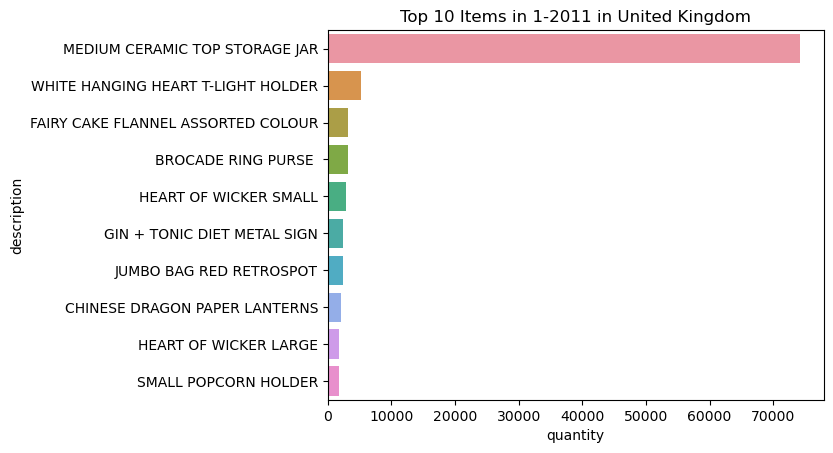

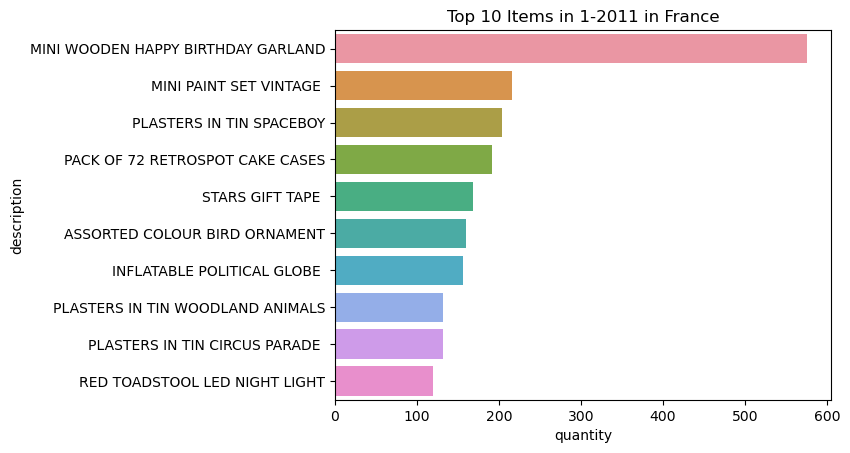

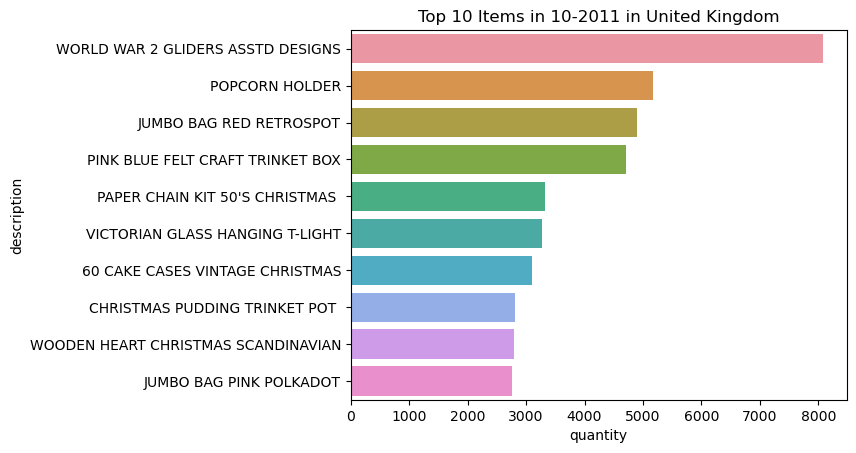

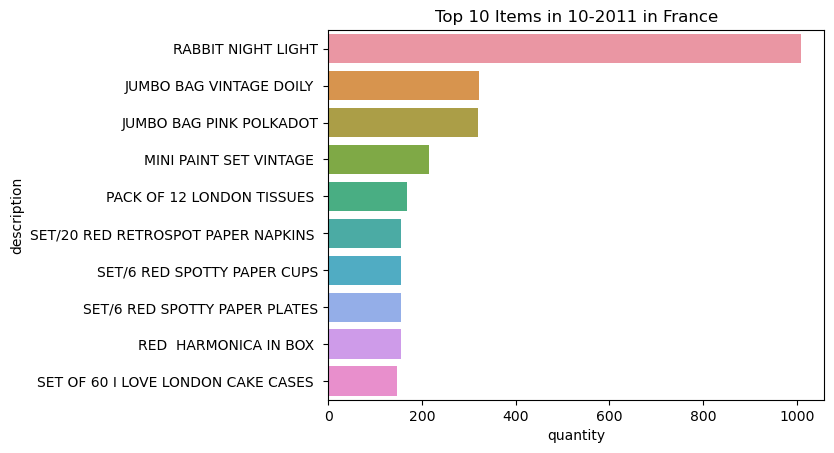

In [15]:
for month_year in monthwise_popularity['month_year'].unique()[:2]:
    
    for country in df['country'].unique()[:2]:
        
        sns.barplot(x='quantity', y='description', data=monthwise_popularity[ (monthwise_popularity['month_year'] == month_year) & (monthwise_popularity['country'] == country) ] [['description', 'quantity']].sort_values(by='quantity', ascending=False).head(10))
        plt.title('Top 10 Items in '+ month_year +' in '+ country)
        plt.show()


In [16]:
# Function to find items previously bought by each customer and recommend as 'Buy Again'

def buy_again(customer_id):
    
    items_bought = df[ df['customer_id'] == customer_id].description
    bought_again = Counter(items_bought)
    buy_again_list = pd.Series(list(bought_again))
    
    print('\nRecommendations For Customer ID ' + str(customer_id) + '\nItems you might consider buying again:\n\n', buy_again_list)

We check **Buy Again** recommendations for a test customer.

In [17]:
buy_again(17850)


Recommendations For Customer ID 17850
Items you might consider buying again:

 0      WHITE HANGING HEART T-LIGHT HOLDER
1                     WHITE METAL LANTERN
2          CREAM CUPID HEARTS COAT HANGER
3     KNITTED UNION FLAG HOT WATER BOTTLE
4          RED WOOLLY HOTTIE WHITE HEART.
5            SET 7 BABUSHKA NESTING BOXES
6       GLASS STAR FROSTED T-LIGHT HOLDER
7                  HAND WARMER UNION JACK
8               HAND WARMER RED POLKA DOT
9                   EDWARDIAN PARASOL RED
10             RETRO COFFEE MUGS ASSORTED
11                    SAVE THE PLANET MUG
12         VINTAGE BILLBOARD DRINK ME MUG
13        VINTAGE BILLBOARD LOVE/HATE MUG
14     WOOD 2 DRAWER CABINET WHITE FINISH
15      WOOD S/3 CABINET ANT WHITE FINISH
16      WOODEN PICTURE FRAME WHITE FINISH
17            WOODEN FRAME ANTIQUE WHITE 
18                EDWARDIAN PARASOL BLACK
19               IVORY EMBROIDERED QUILT 
20      JUMBO SHOPPER VINTAGE RED PAISLEY
dtype: object


We can list most popular items daily. These give a real-time pulse to customers and can be seen as **daily trending items**.

In [18]:
# Generating a pivot of total quantities ordered for each item on each day

df['date'] = df['invoice_date'].map(lambda x: x.strftime('%y-%m-%d'))
datewise_sales = df.pivot_table(index=['date','stock_code','description'], values='quantity', 
                                aggfunc='sum').reset_index()
datewise_sales.head()

Feature,date,stock_code,description,quantity
0,10-12-01,10002,INFLATABLE POLITICAL GLOBE,60
1,10-12-01,10125,MINI FUNKY DESIGN TAPES,2
2,10-12-01,10133,COLOURING PENCILS BROWN TUBE,5
3,10-12-01,10135,COLOURING PENCILS BROWN TUBE,1
4,10-12-01,11001,ASSTD DESIGN RACING CAR PEN,3


In [19]:
# Function to show top 10 most ordered items on a specified date.

def trending(date):
    ax = sns.barplot(y='description', x='quantity', 
                     data=datewise_sales[datewise_sales['date']==date].sort_values(by='quantity', 
                                                                                   ascending=False).head(10))
    ax.set_title('Top 10 Trending Items on {0}'.format(date), fontsize=14)
    ax.set_ylabel('Item')

We check the trending items for some test cases below.

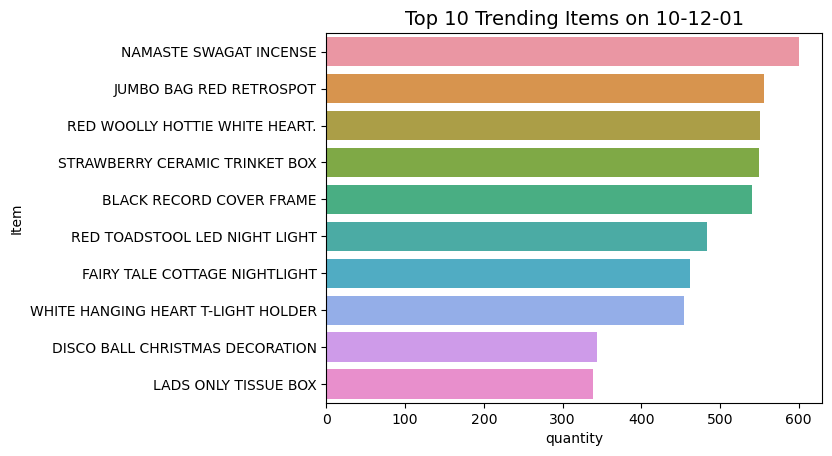

In [20]:
trending('10-12-01')

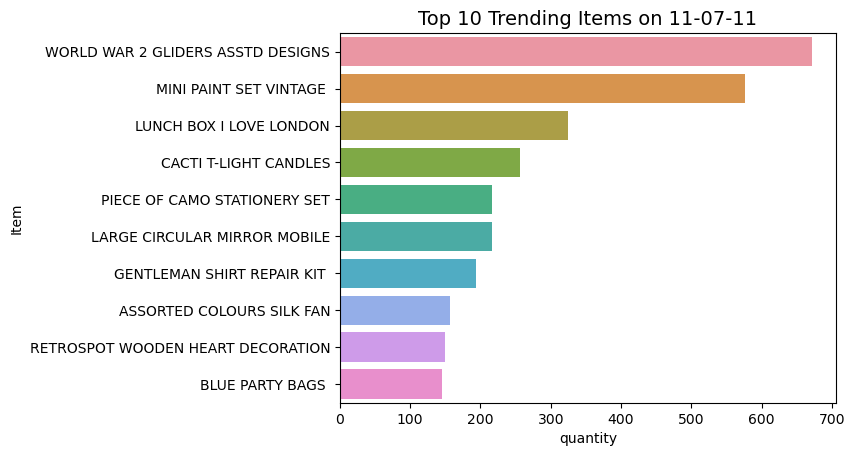

In [21]:
trending('11-07-11')

A day wise list of least selling items could be used to identify which items to provide deals on, as their sales need extra incentives. These could be presented as **Deal of the Day**.

In [22]:
# Function to generate least selling items for each day to be recommended as Deal of the Day.

def deal_of_the_day(date):
    
    data = datewise_sales[datewise_sales['date']==date].sort_values(by='quantity')
    
    print('Items to consider for deals on {0}\n'.format(date))
    print(data['description'].head(10))

We check the **deals of the day** for some test cases below.

In [23]:
deal_of_the_day('11-12-09')

Items to consider for deals on 11-12-09

276345              LUNCH BAG PINK POLKADOT
276378                    PLASMATRONIC LAMP
276889                  WASHROOM METAL SIGN
276375             BIRDHOUSE GARDEN MARKER 
276373              SPACEBOY TV DINNER TRAY
276372          TV DINNER TRAY AIR HOSTESS 
276891                  BATHROOM METAL SIGN
276893            AREA PATROLLED METAL SIGN
276903      GREETING CARD,SQUARE, DOUGHNUTS
276360    GROW YOUR OWN BASIL IN ENAMEL MUG
Name: description, dtype: object


In [24]:
deal_of_the_day('11-11-07')

Items to consider for deals on 11-11-07

237624           BUTTERFLY CROCHET FOOD COVER
237617              BROWN CHECK CAT DOORSTOP 
237618            GINGHAM HEART  DOORSTOP RED
237619    SET3 BOOK BOX GREEN GINGHAM FLOWER 
237873                 ENAMEL BREAD BIN CREAM
238129          SILVER BELLS TABLE DECORATION
237622                   BASKET OF TOADSTOOLS
237623          RED FLOWER CROCHET FOOD COVER
237876          PENCIL CASE LIFE IS BEAUTIFUL
238151                    REGENCY SUGAR TONGS
Name: description, dtype: object


Next, we create a separate field for net purchase amount for each transaction. This will help in total revenue calculations.

In [25]:
df['amount'] = df['unit_price'] * df['quantity']

In [26]:
orders = df.groupby(by=['customer_id', 'country'], as_index=False)['invoice_no'].count()
orders = orders.sort_values(by='invoice_no', ascending=False).reset_index(drop=True)
orders['customer_id'] = orders['customer_id'].astype('int64')
orders.rename({'invoice_no': 'orders'}, axis=1, inplace=True)
orders.head(10)

Feature,customer_id,country,orders
0,17841,United Kingdom,7847
1,14911,EIRE,5677
2,14096,United Kingdom,5111
3,12748,United Kingdom,4596
4,14606,United Kingdom,2700
5,15311,United Kingdom,2379
6,14646,Netherlands,2080
7,13089,United Kingdom,1818
8,13263,United Kingdom,1677
9,14298,United Kingdom,1637


We briefly check the number of orders placed by different customers across the world.

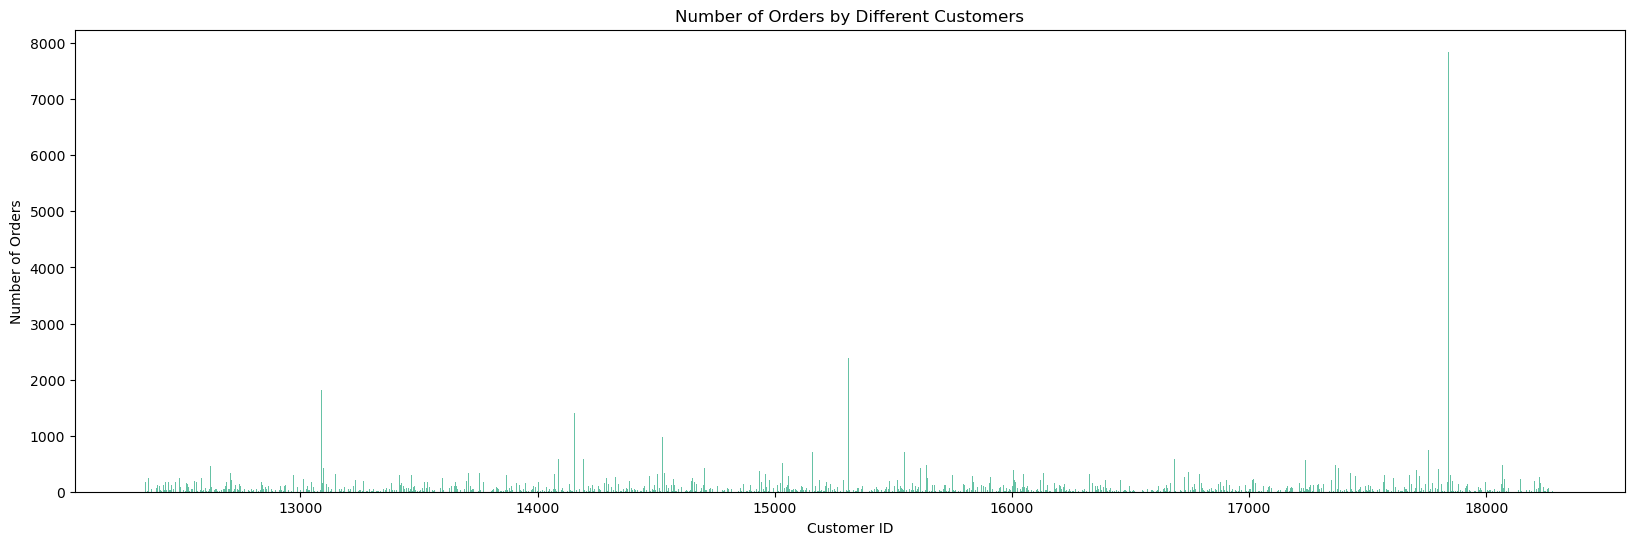

In [27]:
plt.subplots(figsize=(20, 6))
plt.xlabel('Customer ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by Different Customers')
plt.bar(orders.customer_id, orders.orders)
plt.show()

The business metric, more important to us, is the amount spent by customers, not just the number of orders.

In [28]:
money_spent = df.groupby(by=['customer_id', 'country'], as_index=False)['amount'].sum()
money_spent = money_spent.sort_values(by='amount', ascending=False).reset_index(drop=True)
money_spent['customer_id'] = money_spent['customer_id'].astype('int64')
money_spent.head(10)

Feature,customer_id,country,amount
0,14646,Netherlands,280206.02
1,18102,United Kingdom,259657.30
2,17450,United Kingdom,194550.79
3,16446,United Kingdom,168472.50
4,14911,EIRE,143825.06
5,12415,Australia,124914.53
6,14156,EIRE,117379.63
7,17511,United Kingdom,91062.38
8,16029,United Kingdom,81024.84
9,12346,United Kingdom,77183.60


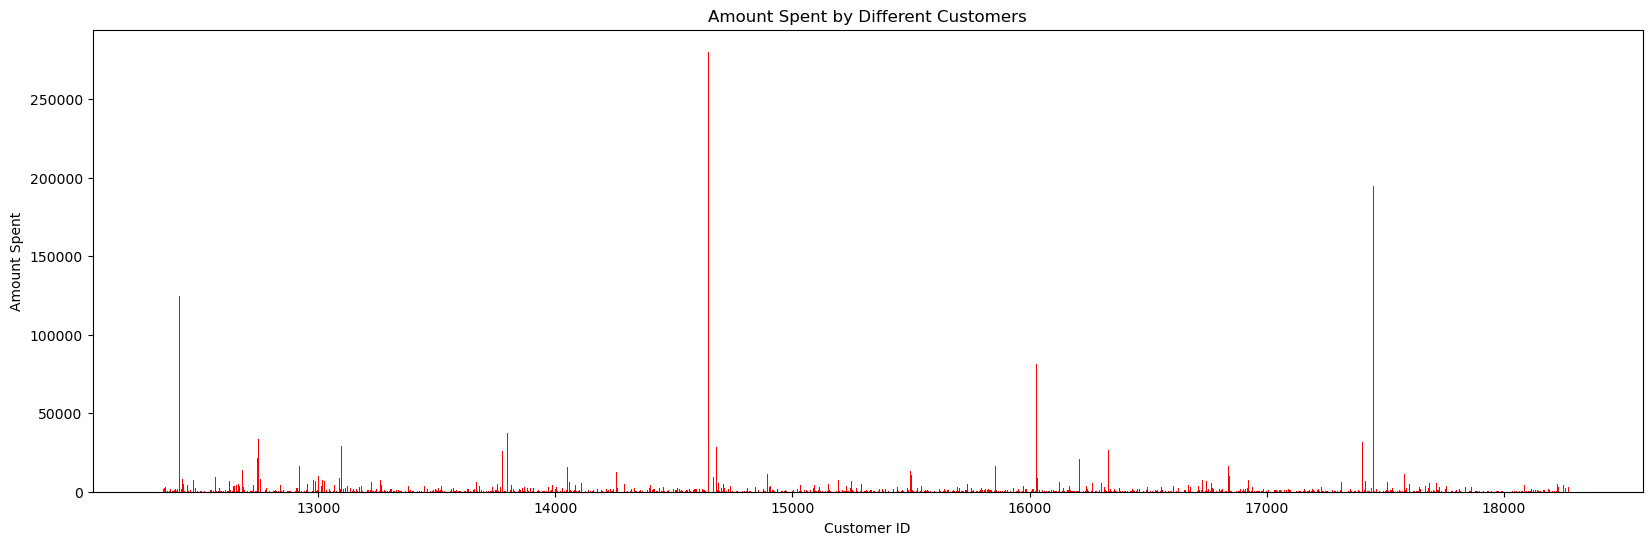

In [29]:
plt.subplots(figsize=(20, 6))
plt.xlabel("Customer ID")
plt.ylabel('Amount Spent')
plt.title('Amount Spent by Different Customers')
plt.bar(money_spent.customer_id, money_spent.amount, color='red')
plt.show()

The plot above confirms that a handful of customers are spending the maximum amount. The customers ordering most frequently are not necessarily spending the most.  
We next check during which months, days and times in a day, are maximum orders being placed.

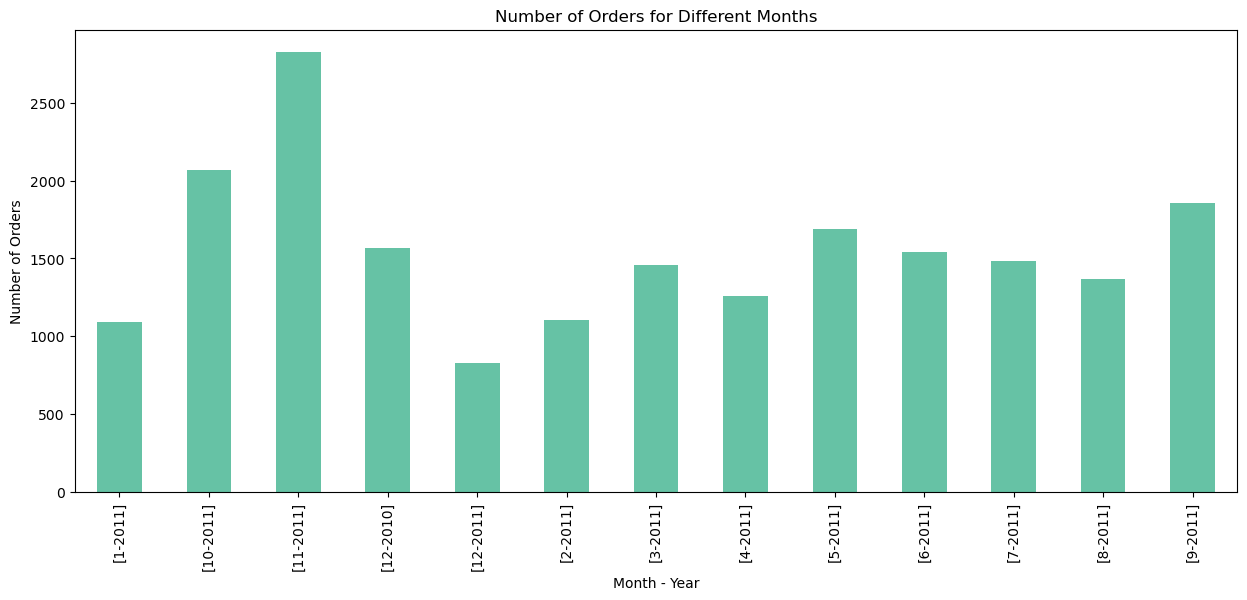

In [30]:
ax = df.groupby('invoice_no')['month_year'].unique().value_counts().sort_index().plot(kind='bar', figsize=(15, 6))

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of Orders')
ax.set_title('Number of Orders for Different Months')
plt.show()

Maximum orders are placed during October and November. The orders placed in December have a considerable variation across 2010 and 2011.

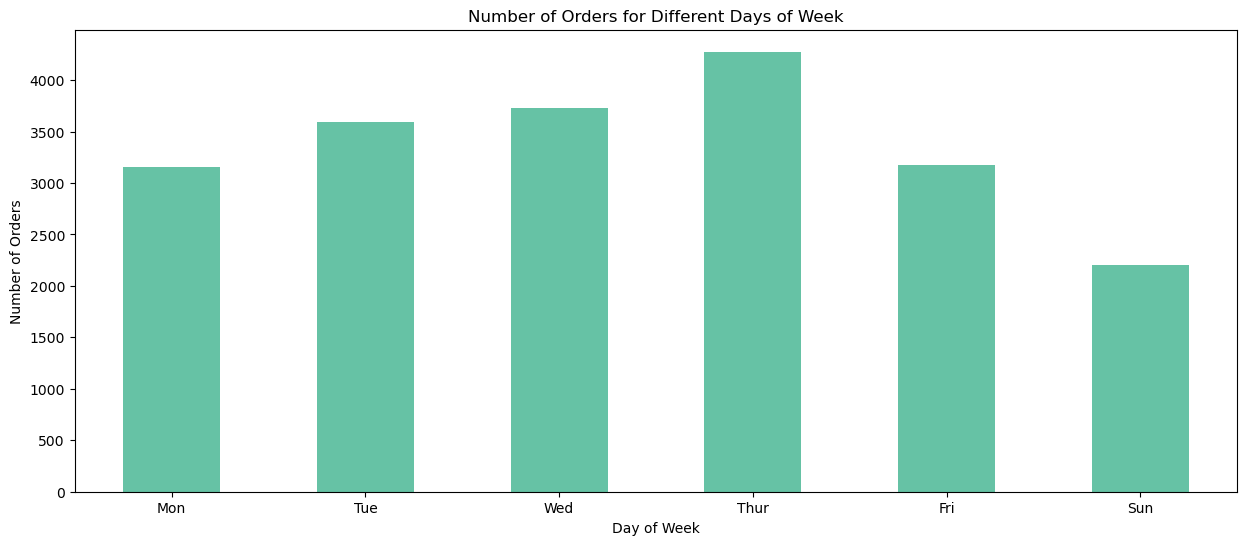

In [31]:
ax = df.groupby('invoice_no')['day'].unique().value_counts().sort_index().plot(kind='bar', figsize=(15, 6))

ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Orders')
ax.set_title('Number of Orders for Different Days of Week')
ax.set_xticklabels(labels=('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sun'), rotation='horizontal')
plt.show()

We find that no orders are placed on a Saturday!

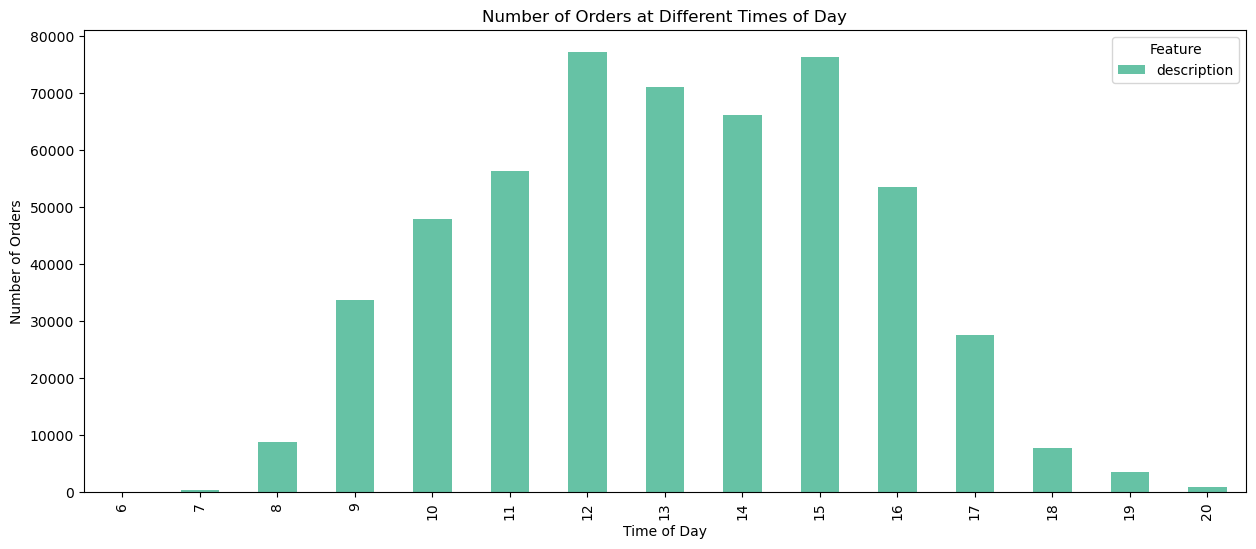

In [32]:
ax = df.pivot_table('description', index='hour', aggfunc='count').plot(kind='bar',figsize=(15,6))
ax.set_xlabel('Time of Day')
ax.set_ylabel('Number of Orders')
ax.set_title('Number of Orders at Different Times of Day')
plt.show()

We also find that most orders are placed during the mid-day hours, typically before and after lunch hours.

In [33]:
df['unit_price'].describe()

count    530693.000000
mean          3.861599
std          41.833162
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: unit_price, dtype: float64

A lot of items have a unit price of 0 or negative. Dropping all records with missing values in the dataset also removes all negative values for unit price. In the remaining records, we find the summary for unit prices as follows.

In [34]:
df.dropna(inplace=True)

In the remaining records, we find the summary for unit prices as follows.

In [35]:
df['unit_price'].describe()

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: unit_price, dtype: float64

We notice the sharp difference between 75 percentile counts and the maximum unit prices. A box plot helps us visualise this variation clearly.

<Axes: >

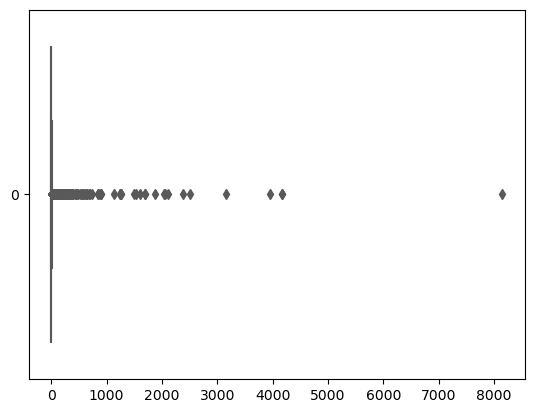

In [36]:
sns.boxplot(df['unit_price'], orient='h')

This shows that items with zero unit price are not merely outliers but free items. We next explore how these free items impact the sales.  
We isolate all the free items and check how many free items were on offer during different months.

<Axes: >

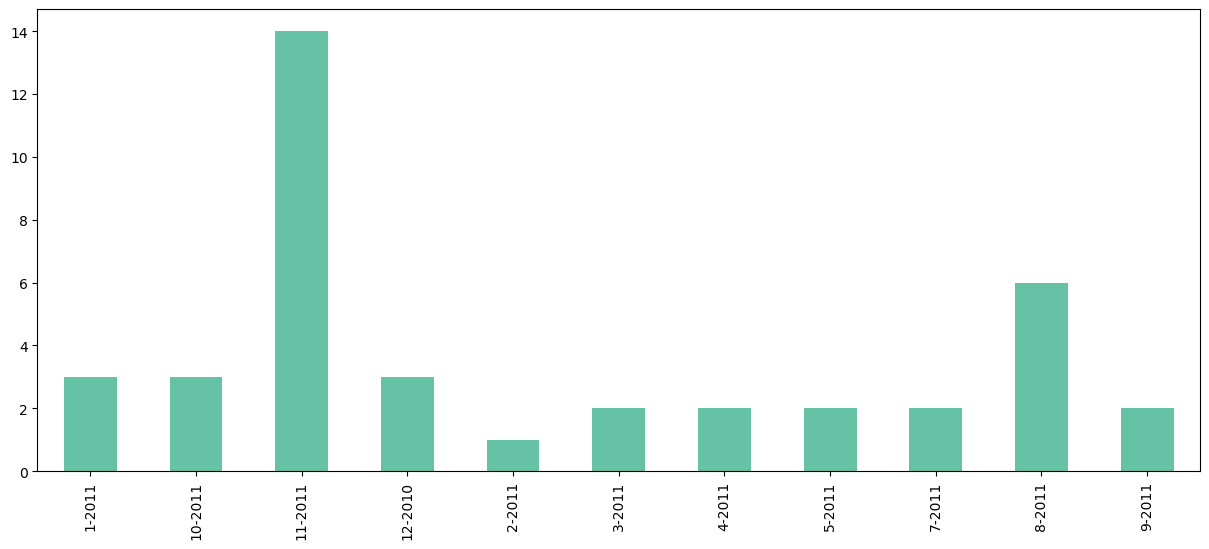

In [37]:
df[df['unit_price'] == 0] ['month_year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 6))

Above shows that at least one free item was on offer during each month except June, 2011. Most free items were on offer during November, 2011. Maximum orders were also placed during the same month, as shown below.

<Axes: xlabel='month_year'>

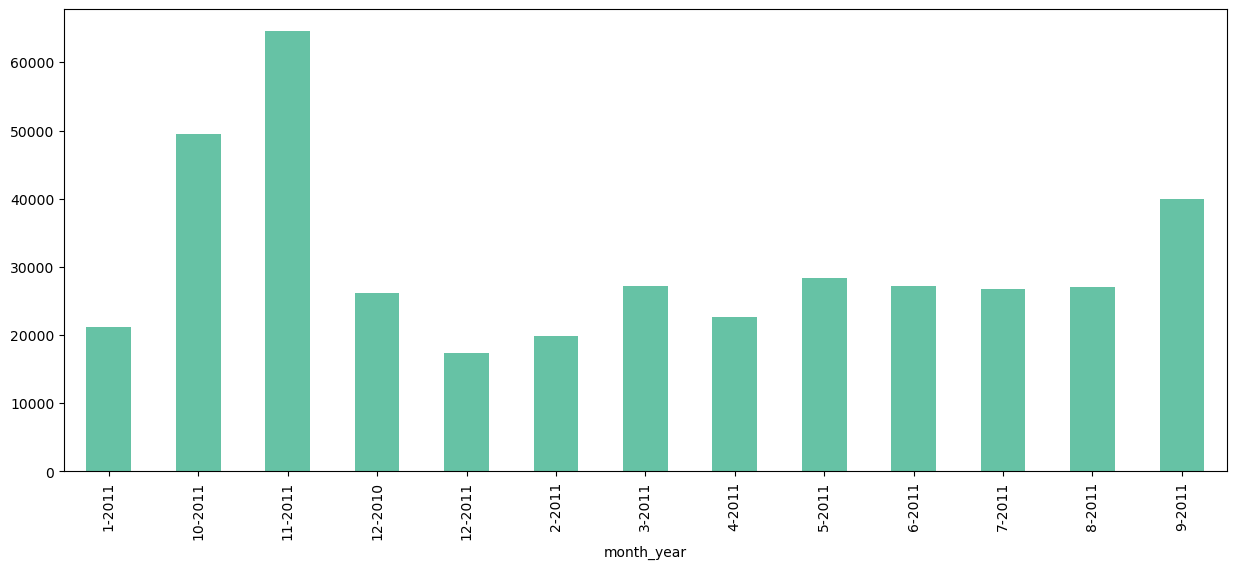

In [38]:
df.groupby('month_year')['invoice_no'].count().sort_index().plot(kind='bar', figsize=(15, 6))

However, the correlation is not very definite. When free items are withdrawn during June, the orders do go
down slightly. But as more free items are added during July and August, the number of orders in fact decrease
steadily.  

To get a closer look, we plot the revenue generated during these months, and not just the total orders.

<Axes: xlabel='month_year'>

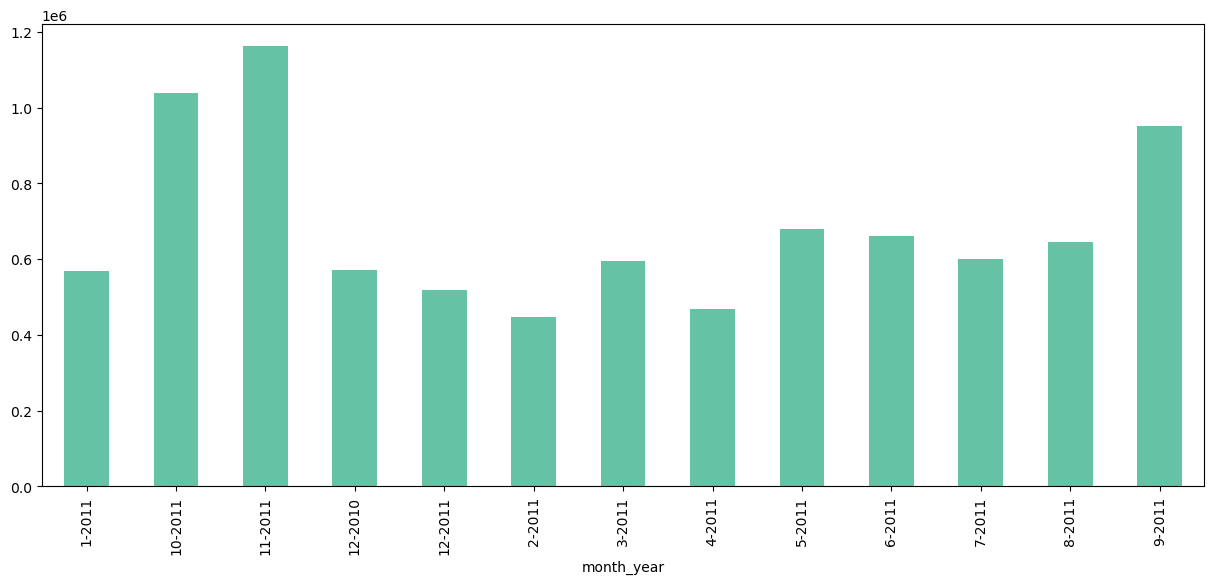

In [39]:
df.groupby('month_year')['amount'].sum().sort_index().plot(kind='bar', figsize=(15, 6))

We see that although more free items were given during July and August than in June, the net revenue gained in these months is still smaller than that in June. So, free items, by themselves, may not be adequate to boost total orders or revenue.  
We now narrow down to item-level purchase patterns. First, we check the top items based on quantities
ordered

Text(0.5, 1.0, 'Top 10 Items based on Quantities Ordered')

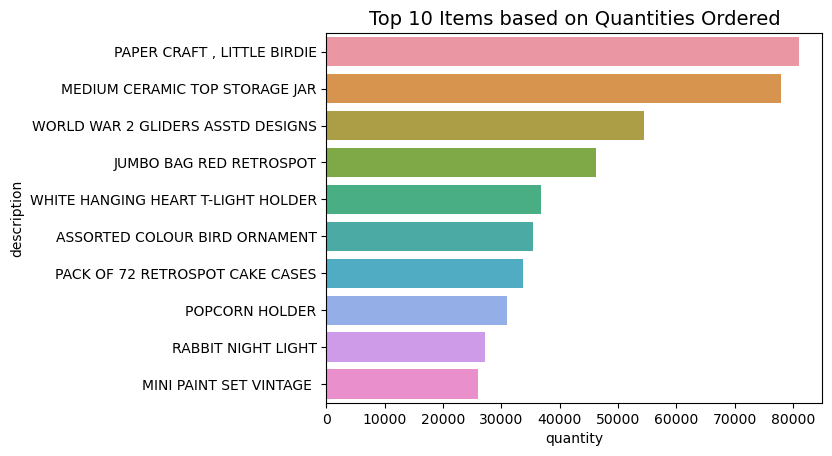

In [40]:
most_sold = df.pivot_table('quantity', index='description', aggfunc='sum').sort_values('quantity', ascending=False).reset_index()
top_10_most_sold = most_sold.head(10)['description'].to_list()
ax = sns.barplot(x='quantity', y='description', data=most_sold.head(10), orient='h')
ax.set_title('Top 10 Items based on Quantities Ordered', fontsize=14)


Depending on criteria, the top 10 items may change. Below we have the top 10 items based on the number of unique orders placed for each (identifiable by invoice numbers).

Text(0.5, 1.0, 'Top 10 Items based on Number of Unique Orders')

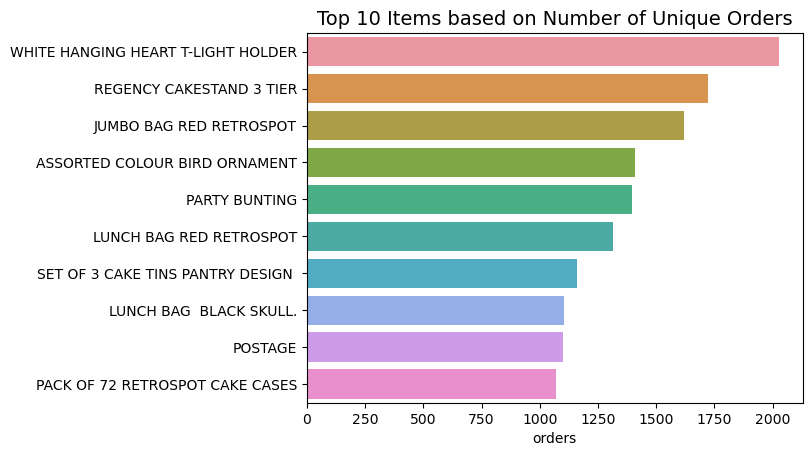

In [41]:
ordered_most = df.pivot_table('invoice_no', index='description', aggfunc='count').sort_values('invoice_no', ascending=False)
ordered_most.rename({'invoice_no': 'orders'}, axis=1, inplace=True)
ax = sns.barplot(x='orders', y=ordered_most.index.values[:10], data=ordered_most.head(10), orient='h')
ax.set_title('Top 10 Items based on Number of Unique Orders', fontsize=14)                 

Finally, we have the top 10 items based on the number of distinct customers ordering them.

Text(0.5, 1.0, 'Top 10 Items based on Number of Customers Ordering')

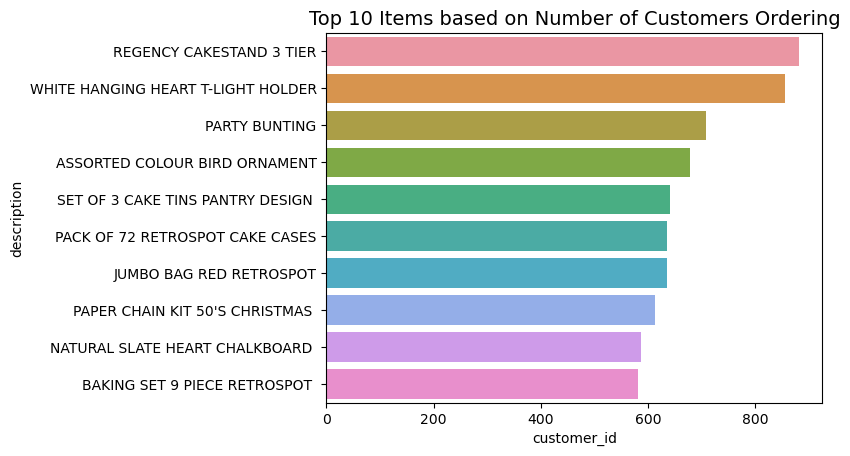

In [42]:
bought_by_most = df.pivot_table('customer_id', index='description', aggfunc=lambda x: len(x.unique())).sort_values('customer_id', ascending=False).reset_index()

ax = sns.barplot(x='customer_id', y='description', data=bought_by_most.head(10), orient='h')
ax.set_title('Top 10 Items based on Number of Customers Ordering', fontsize=14)

An item may also be considered popular if it happens to be the first item in a maximum number of orders.

In [43]:
df['items'] = df['description'].str.replace(' ', '_')

In [44]:
invoices = list(set(df['invoice_no'].to_list()))

In [45]:
first_purchases = []

for invoice in invoices:
    
    first_purchase = df[df['invoice_no'] == invoice]['items'].reset_index(drop=True)[0]
    first_purchases.append(first_purchase)

first_purchases[:10]

['ABC_TREASURE_BOOK_BOX_',
 'HAND_WARMER_UNION_JACK',
 "PAPER_CHAIN_KIT_50'S_CHRISTMAS_",
 'CERAMIC_STRAWBERRY_CAKE_MONEY_BANK',
 'RETROSPOT_CHILDRENS_APRON',
 'MAGAZINE_RACK_GEBRA_ASSORTED_',
 'POTTING_SHED_TEA_MUG',
 "JUMBO_BAG_50'S_CHRISTMAS_",
 'JUMBO_BAG_PINK_VINTAGE_PAISLEY',
 'BOX_OF_6_MINI_VINTAGE_CRACKERS']

In [46]:
counts = Counter(first_purchases)

df_first_purchase = pd.DataFrame.from_dict(counts, orient='index').reset_index()

df_first_purchase.rename(columns={'index': 'item', 0: 'count'}, inplace=True)
df_first_purchase.sort_values('count', ascending=False)

,item,count
245,REGENCY_CAKESTAND_3_TIER,203
26,WHITE_HANGING_HEART_T-LIGHT_HOLDER,181
76,RABBIT_NIGHT_LIGHT,155
35,PARTY_BUNTING,122
54,Manual,119
...,...,...
2188,FOLKART_CLIP_ON_STARS,1
1250,HAND_OPEN_SHAPE_DECO.WHITE,1
2190,LA_PALMIERA_TILE_COASTER,1
1852,FRENCH_STYLE_STORAGE_JAR_JAM,1


Text(0.5, 1.0, 'Top 10 Items Featuring as First Purchases across Maximum Orders')

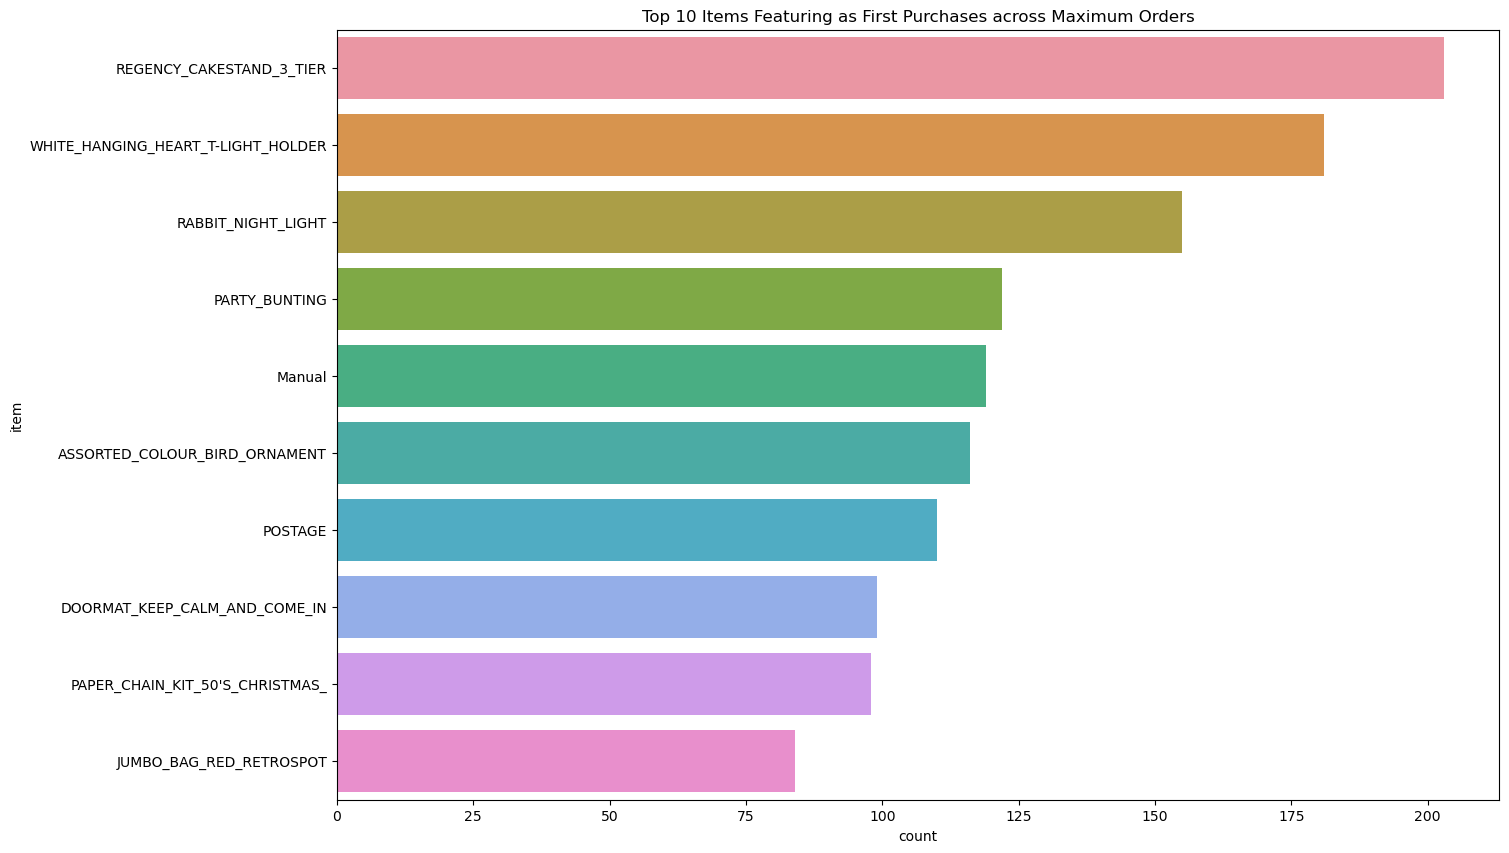

In [47]:
plt.subplots(figsize=(15, 10))
ax = sns.barplot(x='count', y='item', data=df_first_purchase.sort_values('count', ascending=False).head(10), orient='h')
ax.set_title('Top 10 Items Featuring as First Purchases across Maximum Orders')

## Recommendations using Market Basket Analysis

We now implement **Market Basket Analysis** on the transactional data. 

Statistically, the model is a form of **affinity analysis**. It helps us estimate likelihoods of specific sets of items being bought together, and identify item-sets which are most commonly bundled together in a transaction (invoice). 

This improves customer experience, inventory management, and aids in targeted advertising. It can recommend to customers, based on a purchase, which item to buy next.

We draw upon three key metrics:  

**Support (X -> Y)** = Transactions containing both X and Y / Total Number of Transactions

**Lift (X -> Y)** = Transactions containing both X and Y / Transactions containing X

**Confidence (X -> Y)** = Transactions containing both X and Y/Transactions containing X / Fraction of Transactions containing Y = % Confidence / % Support

We can use multiple algorithms for this analysis (AIS, SETM, FP Growth) but here we start with **Apriori algorithm using MLXTend libraries**.  

We proceed in two stages: 

(1) Generate frequent item sets  
(2) Generate association rules (X -> Y) with corresponding strengths based on a cut-off.  

First, we create an exhaustive matrix listing combinations each item and invoice, in form of a sparse matrix.

In [48]:
basket = df.groupby(['invoice_no', 'description'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('invoice_no')

In [49]:
def encode(x):
    
    if x < 1:
        return 0
    if x >=1:
        return 1

In [50]:
basket = basket.applymap(encode)
basket.head(10)

description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
invoice_no,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Vertical sum of each column gives the number of transactions an item is a part of.  
Horizontal sum shows the number of items in each transaction.

In [51]:
basket_item_sum = pd.DataFrame(basket.sum().sort_values(ascending=False))
basket_item_sum.rename({0: 'Number of transactions'}, axis=1).head(10)

,Number of transactions
description,
WHITE HANGING HEART T-LIGHT HOLDER,1971
REGENCY CAKESTAND 3 TIER,1704
JUMBO BAG RED RETROSPOT,1600
PARTY BUNTING,1380
ASSORTED COLOUR BIRD ORNAMENT,1375
LUNCH BAG RED RETROSPOT,1288
SET OF 3 CAKE TINS PANTRY DESIGN,1146
POSTAGE,1099
LUNCH BAG BLACK SKULL.,1052


In [52]:
basket_invoice_sum = pd.DataFrame(basket.sum(axis=1).sort_values(ascending=False))
basket_invoice_sum.rename({0: 'Number of transactions'}, axis=1).head(10)

,Number of transactions
invoice_no,
576339,541
579196,529
580727,525
578270,439
573576,434
567656,419
567183,386
575607,375
571441,363


For each item, we can create a boolean sparse matrix detailing the invoices it was a part of, and other accompanying items in those transactions.  
Apriori algorithm takes this sparse matrix as input and for each item, generates a list of items frequently bought together with it.   
Finally, it generates a set of association rules involving the item and others frequently bought alongside. 

In [53]:
sample_basket = basket.loc[basket['WHITE HANGING HEART T-LIGHT HOLDER'] == 1]
sample_basket = sample_basket.astype(bool)

frequent_itemsets = apriori(sample_basket, min_support=0.15, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.230847,(RED HANGING HEART T-LIGHT HOLDER)
1,1.000000,(WHITE HANGING HEART T-LIGHT HOLDER)
2,0.156266,(WOODEN PICTURE FRAME WHITE FINISH)
3,0.230847,"(WHITE HANGING HEART T-LIGHT HOLDER, RED HANGI..."
4,0.156266,"(WHITE HANGING HEART T-LIGHT HOLDER, WOODEN PI..."


In [54]:
sample_rule = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
sample_rule.sort_values(['lift','support'],ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(WHITE HANGING HEART T-LIGHT HOLDER),(RED HANGING HEART T-LIGHT HOLDER),1.000000,0.230847,0.230847,0.230847,1.0,0.0,1.0,0.0
1,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.230847,1.000000,0.230847,1.000000,1.0,0.0,inf,0.0
2,(WHITE HANGING HEART T-LIGHT HOLDER),(WOODEN PICTURE FRAME WHITE FINISH),1.000000,0.156266,0.156266,0.156266,1.0,0.0,1.0,0.0
3,(WOODEN PICTURE FRAME WHITE FINISH),(WHITE HANGING HEART T-LIGHT HOLDER),0.156266,1.000000,0.156266,1.000000,1.0,0.0,inf,0.0


We specify a minimum support value of 0.15 and minimum threshold of 1 for association rules.

In [55]:
# Function to generate list of associated items

def frequently_bought_together(item):
    
    item_df = basket.loc[basket[item]==1].astype(bool)
    
    frequent_itemsets = apriori(item_df, min_support=0.15, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    rules.sort_values(['lift','support'],ascending=False).reset_index(drop=True)
        
    recommended_list = []

    for recommended_item in rules['consequents'].unique()[:6]:

        recommended_list.append(list(recommended_item))
    
    print('Items frequently bought together with {0}'.format(item))
    return rules['consequents'].unique()[:6]

We validate using a few test cases.

In [56]:
frequently_bought_together('CREAM CUPID HEARTS COAT HANGER')

Items frequently bought together with CREAM CUPID HEARTS COAT HANGER


array([frozenset({'ENCHANTED BIRD COATHANGER 5 HOOK'}),
       frozenset({'CREAM CUPID HEARTS COAT HANGER'}),
       frozenset({'FOUR HOOK  WHITE LOVEBIRDS'}),
       frozenset({'METAL 4 HOOK HANGER FRENCH CHATEAU'}),
       frozenset({'WHITE HANGING HEART T-LIGHT HOLDER'}),
       frozenset({'WOOD 2 DRAWER CABINET WHITE FINISH'})], dtype=object)

We check if associated items are actually found together in the same invoice. Indeed, they are!

In [57]:
df[df['invoice_no']=='536373']['description']

49     WHITE HANGING HEART T-LIGHT HOLDER
50                    WHITE METAL LANTERN
51         CREAM CUPID HEARTS COAT HANGER
52                  EDWARDIAN PARASOL RED
53             RETRO COFFEE MUGS ASSORTED
54                    SAVE THE PLANET MUG
55         VINTAGE BILLBOARD DRINK ME MUG
56        VINTAGE BILLBOARD LOVE/HATE MUG
57     WOOD 2 DRAWER CABINET WHITE FINISH
58      WOOD S/3 CABINET ANT WHITE FINISH
59      WOODEN PICTURE FRAME WHITE FINISH
60            WOODEN FRAME ANTIQUE WHITE 
61    KNITTED UNION FLAG HOT WATER BOTTLE
62         RED WOOLLY HOTTIE WHITE HEART.
63           SET 7 BABUSHKA NESTING BOXES
64      GLASS STAR FROSTED T-LIGHT HOLDER
Name: description, dtype: object

In [58]:
frequently_bought_together('RETRO COFFEE MUGS ASSORTED')

Items frequently bought together with RETRO COFFEE MUGS ASSORTED


array([frozenset({'CREAM CUPID HEARTS COAT HANGER'}),
       frozenset({'RETRO COFFEE MUGS ASSORTED'}),
       frozenset({'HOME SWEET HOME MUG'}),
       frozenset({'KINGS CHOICE MUG'}),
       frozenset({'RED WOOLLY HOTTIE WHITE HEART.'}),
       frozenset({'KNITTED UNION FLAG HOT WATER BOTTLE'})], dtype=object)

## Recommendations using Collaborative Filtering  

**Collaborative filtering** uses historical data of customer-item interactions to recommend to a customer,  

a. items purchased by other customers with purchase profiles similar to her **(Customer-based)**  
b. items which are most similar to her previous purchases **(Item-based)**  

### Customer-based Collaborative Filtering

For each customer, this method first shows the purchase profile as a list. It then tries to find customers who have a similar purchase profile, i.e., have purchased similar items. As a measure of similarity to compare two purchase profiles, we use the cosine similarity. And finally to that customer, this method recommends the items purchased by customers with a purchase profile similar to hers.  

We first create a boolean, sparse matrix showing quantities of different items purchased by all customers.

In [59]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

In [60]:
purchase = df.groupby(['customer_id', 
                       'stock_code'])['quantity'].sum().unstack().reset_index().fillna(0).set_index(
    'customer_id')
purchase = purchase.applymap(encode)
customer_similarity = cosine_similarity(purchase)
customer_similarity_df = pd.DataFrame(customer_similarity,index=purchase.index,columns=purchase.index)

In [61]:
purchase.head()

stock_code,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
customer_id,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [62]:
# Function to get customers with similar purchasing profiles, for a specified customer

def similar_customers(customer_id,k=5):

    customer = customer_similarity_df[customer_similarity_df.index == customer_id]
    other_customers = customer_similarity_df[customer_similarity_df.index != customer_id]
    
    customer_similarity = cosine_similarity(customer, other_customers)[0].tolist()    
    indices = other_customers.index.tolist()
    
    customer_similarity = dict(zip(indices, customer_similarity))    
    sorted_customer_similarity = sorted(customer_similarity.items(), key=lambda x:x[1], reverse=True)
    
    top_similar_customers = sorted_customer_similarity[:k]
    customers = [int(c[0]) for c in top_similar_customers]
    
    print('The customers with purchase profiles similar to Customer {0} are: \n\n'.format(customer_id), customers)
    
    return customers

For any given customer, we can generate a list of five customers with purchase profiles most similar to hers. Some test cases are shown below.

In [63]:
similar_customers(12682)

The customers with purchase profiles similar to Customer 12682 are: 

 [12567, 14646, 12415, 12681, 12637]


[12567, 14646, 12415, 12681, 12637]

In [64]:
similar_customers(14646)

The customers with purchase profiles similar to Customer 14646 are: 

 [12415, 14911, 12748, 14096, 14456]


[12415, 14911, 12748, 14096, 14456]

Different customers may have an overlapping list of similar customers. Customers may also be clustered in affinity groups.  
Finally, we collate the list of all items purchased by the top 5 similar customers and recommend a randomly selected sample of 10 items.

In [65]:
# Function to generate recommendations based on purchase history of similar customers

def similar_customers_recommend(customer_id):
    
    sim_customers = similar_customers(customer_id)

    reco_list = []
    
    for j in sim_customers:
        
        item = df[df["customer_id"]==j]['stock_code'].to_list()
        reco_list.append(item)
        
    reco_list = [i for sublist in reco_list for i in sublist]    
    recommended_items = random.sample(set(reco_list), 10)
    
    print('\n\nTop 10 items bought by customers with similar purchasing patterns as Customer {0} are: '.format(customer_id))
    
    return recommended_items

In [66]:
similar_customers_recommend(16062)

The customers with purchase profiles similar to Customer 16062 are: 

 [15150, 12540, 17511, 17377, 16655]


Top 10 items bought by customers with similar purchasing patterns as Customer 16062 are: 


['23460',
 '21243',
 '23502',
 '22625',
 '22917',
 '22588',
 '23370',
 '22970',
 '20668',
 '21878']

In [67]:
similar_customers_recommend(17511)

The customers with purchase profiles similar to Customer 17511 are: 

 [14646, 12748, 14911, 13089, 14156]


Top 10 items bought by customers with similar purchasing patterns as Customer 17511 are: 


['16052',
 '23367',
 '22713',
 '72817',
 '21984',
 '22837',
 '85213',
 '22686',
 '22046',
 '85055']

The above approach is similar to segregating all customers in some clusters, and to each customer, recommending items purchased by its 5 nearest neighbours in the cluster. All the customers in a cluster have a certain, similar, distinctive purchase profile.  

We assume here that *past user-item interactions are sufficient to detect similar users or similar items, and to predict sales outcomes of future user-item interactions*.  

The strength of this method lies in that *clustering, an unsupervised task, is done automatically without us needing to hard-code attributes of each customer's purchase profile.*  

Here, we represent each customer's purchase profile as a vector and use dot product to compare two such profiles. This requires a significant history of customer-item interactions to generate non-vanishing dot products.  

So, this method is unsuitable for the early phase of customer's interactions **(cold start problem)**.

**Item-based Collaborative Filtering**

For each item, this method first lists all the customers who purchased it, and then lists other items purchased by these customers. On this basis, it finds cosine similarity between each item pair.

We first create a boolean, sparse matrix to show all purchasers of all the items.

In [68]:
item_basket = (df.groupby(['stock_code','customer_id'])['quantity'].sum().unstack().reset_index().fillna(
    0).set_index('stock_code'))
item_basket.applymap(encode)
item_similarity = cosine_similarity(item_basket)
item_similarity_df = pd.DataFrame(item_similarity,index=item_basket.index,columns=item_basket.index)

The purchaser profile of each item is shown as a row. The first few rows are shown below.

In [69]:
item_similarity_df.head(10)

stock_code,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
stock_code,,,,,,,,,,,,,,,,,,,,,
10002,1.000000,0.000000,0.001548,0.000990,0.000000,0.000000,0.853890,0.052085,0.021921,0.003033,...,0.000000,0.0,0.000000,0.0,0.000000,0.038765,0.000000,0.000308,0.000000,0.074260
10080,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.004958,0.020646,0.011878,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000
10120,0.001548,0.000000,1.000000,0.004903,0.000000,0.000000,0.001600,0.042543,0.010420,0.009962,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.007664,0.000000,0.000331
10123C,0.000990,0.000000,0.004903,1.000000,0.000000,0.000000,0.004417,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10124A,0.000000,0.000000,0.000000,0.000000,1.000000,0.491784,0.001099,0.014967,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10124G,0.000000,0.000000,0.000000,0.000000,0.491784,1.000000,0.003919,0.013341,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10125,0.853890,0.004958,0.001600,0.004417,0.001099,0.003919,1.000000,0.011629,0.006546,0.002763,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000132,0.000000,0.039080
10133,0.052085,0.020646,0.042543,0.000000,0.014967,0.013341,0.011629,1.000000,0.224185,0.007335,...,0.000000,0.0,0.000000,0.0,0.000000,0.064765,0.000000,0.004308,0.028496,0.003754
10135,0.021921,0.011878,0.010420,0.000000,0.000000,0.000000,0.006546,0.224185,1.000000,0.018743,...,0.002997,0.0,0.000368,0.0,0.004558,0.153785,0.153667,0.004973,0.000000,0.025220


For each item row (purchaser profile), we find the cosine similarity between this and all the other rows. We finally recommend the top 5 most similar items.

In [70]:
def similar_items(item,k=5):

    item_df = item_similarity_df[item_similarity_df.index == item]
    other_items = item_similarity_df
    
    item_similarity = cosine_similarity(item_df, other_items)[0].tolist()    
    indices = other_items.index.tolist()
    
    item_similarity = dict(zip(indices, item_similarity))    
    sorted_item_similarity = sorted(item_similarity.items(), key=lambda x:x[1], reverse=True)
    
    top_similar_items = sorted_item_similarity[:k+1]
    items = [i[0] for i in top_similar_items[1:]]
    
    print('Top 10 items similar to item {0} are: \n'.format(item), items)
    return items

We can generate recommended items for any item by specifying its stock code as shown below.

In [71]:
similar_items('DOT')

Top 10 items similar to item DOT are: 
 ['85131B', '90119', '90146', '85131D', '90016A']


['85131B', '90119', '90146', '85131D', '90016A']

In [72]:
similar_items('PADS')

Top 10 items similar to item PADS are: 
 ['21591', '84806B', '84800S', '21792', '20836']


['21591', '84806B', '84800S', '21792', '20836']

Item similarity lists may also overlap and show signs of clustering.

## Recommendations using Content-based Filtering

This method relies less on historical data of customer's previous interactions with items or other similar customers, but more on each item's own distinctive features (keywords, attributes). They require domain expert's support in labelling attributes of each item.

However, we use Natural Language Processing approaches here which automate this task. We first list all unique item descriptions. We then use the following **vectorization techniques** to convert text to number representation, which we then use to find various similarities.

1. **Count Vectorizer**: We collate all unique item descriptions, remove uninformative words (stop words) and generate a sparse matrix where each row shows simply the frequencies of each unique keyword in an item.  

2. **TFIDF Vectorizer**: Going beyond just frequencies, this method helps prioritise more informative (but less frequent) terms over less informative (but more frequent) ones. Here we use the metric,  

    **TF-IDF** = (Frequency of a specific word W in a document / Total number of words in that document) x log (Total number of documents / Documents     containing a specific word W )  

    *Words with higher TF-IDF are more important.*  

3. **Word2Vec**: This automated library represents each word as an n-dimensional vector. Words with similar meanings are modelled as closely spaced vectors in this hyperspace. We can choose the size of phrases (n-grams).  

4. **Glove**: This method uses global and not just local information to represent words using vectors. It gives lower weight to frequent word co-occurrences and isolates the more significant ones. This method usually outperforms others, captures meaning of rare words and can work even with a little text.  

5. **FastText**: This method goes into character-level blocks and combines these to form higher-level word embeddings. It can generalise to unknown words.  

6. **Co-occurrence matrix**: This finds how many times two item description keywords have appeared together in the customers' historical purchase data.  

The main function shown below vectorizes the item descriptions and generates top similar items based on cosine similarity.

In [73]:
from gensim import models

from gensim.models import fasttext
from gensim.models.fasttext import load_facebook_model
from gensim.test.utils import datapath

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances

The different vectorization approaches yield distinct vector matrices which we then use to calculate similarity. We also use Gensim libraries to load and initialise the pre-trained models Word2Vec, Glove, FastText. We also create the co-occurrence matrix in advance.  

Before applying pre-trained models, we first clean the item descriptions and keep only the unique ones.

In [74]:
desc_df = df.drop_duplicates(subset=['description'], keep='first')['description'].reset_index(drop=True)
desc_df = desc_df.apply(lambda x: x.lower()).apply(lambda x: re.sub(r'[^\w\s]', '', x))
desc_list = list(desc_df)

Now, we load the pre-trained models.

In [76]:
w2v = models.KeyedVectors.load_word2vec_format('../input/google-word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [77]:
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1,3))

In [78]:
glove_df = pd.read_csv('../input/glove6b300dtxt/glove.6B.300d.txt', sep=" ",
                       quoting=3, header=None, index_col=0)
glove = {key: value.values for key, value in glove_df.T.items()}

In [79]:
fast_text = fasttext.load_facebook_model("../input/fasttext-common-crawl-bin-model/cc.en.300.bin")

In [80]:
# Creating the co-occurrence matrix

vocab = []

for i in desc_list:

    [vocab.append(x) for x in i.split()]

occur_matrix = np.zeros((len(vocab), len(vocab)))

for i, item in enumerate(desc_list):

    words = item.split()

    for j, word in enumerate(words):

        if j != len(words)-1:

            occur_matrix[vocab.index(word)][vocab.index(words[j+1])] += 1

In [81]:
# Function to generate product list from similarity matrix

def get_products(sim_matrix, idx, n, reverse=False):
    
    result = list(enumerate(sim_matrix[idx]))
    sorted_result = sorted(result,key=lambda x:x[1],reverse=reverse)[1:n+1]
    recommended_products =  [{'Recommended Product': desc_df.iloc[x[0]], 
                              'Similarity Score' : round(x[1], 2)} for x in sorted_result]
    
    return pd.DataFrame(recommended_products)    

After vectorization, we use the below three similarity measures to find similar items.

**Cosine Similarity**: This measures the angle between two word vectors. A low cosine similarity value indicates high semantic distance, and vice versa.  
**Manhattan Similarity**: This measures the sum of absolute differences between points across all the dimensions.  
**Euclidean Similarity**: This measures the straight, smallest square rooted distance between two points in a multi-dimensional hyperspace.

In [82]:
# Function to generate similarity matrix from vector matrix

def get_sim(vector_matrix, similarity, idx, n):
    
    if similarity == "cosine":
        
        sim_matrix = cosine_similarity(vector_matrix)
        products = get_products(sim_matrix, idx, n, reverse=True)
        
    elif similarity == "manhattan":
        sim_matrix = manhattan_distances(vector_matrix)
        products = get_products(sim_matrix, idx, n)
        
    else:
        sim_matrix = euclidean_distances(vector_matrix)
        products = get_products(sim_matrix , idx, n)

    return products

In [83]:

# Function to vectorize item description list

def vectorizer(kind):
    
    if kind == 'count':
        vector_matrix = count_vectorizer.fit_transform(desc_list)
        
    elif kind == 'tfidf':
        vector_matrix = tfidf_vectorizer.fit_transform(desc_list)
        
    elif kind == 'occur':
        
        vector_matrix = np.empty((len(desc_list), len(vocab)))
        
        for idx, item in enumerate(desc_list): 
            
            item_vector = np.zeros((len(vocab),))
            count = 0
            
            for word in item.split(): 
                
                try:
                    item_vector += occur_matrix[vocab.index(word)]
                    count += 1

                except:
                    continue

            vector_matrix[idx] = item_vector/count                  
        
    else:
        vector_matrix = np.empty((len(desc_list), 300))

        for idx, item in enumerate(desc_list):

            item_vector = np.zeros((300,))

            for word in item.split():

                try:
                    
                    if kind == 'w2v':
                        item_vector += w2v[word]
                    elif kind == 'glove':
                        item_vector += glove[word]
                    elif kind == 'ft':
                        item_vector += fast_text.wv[word]

                except:
                    continue

            vector_matrix[idx] = item_vector
            
    return vector_matrix

Finally, we sort the top similar items and present them as recommendations.

In [84]:
# Function to generate recommendations

def recommend(description, kind, similarity, n=10):

    idx = desc_df.loc[desc_df==description].index[0]
    vector_matrix = vectorizer(kind)
    products = get_sim(vector_matrix, similarity, idx, n)
    
    return products

For each item, we can specify a preferred vectorization method and a preferred similarity measure to get recommendations for similar items.

Below we show top 10 similarity-based recommendations for a specific item **charlotte bag dolly girl design** using *6 different methods but with the same similarity measure, cosine*.

In [85]:
recommend('charlotte bag dolly girl design', 'count', 'cosine').style.set_caption('Count Vectorization, Cosine')

,Recommended Product,Similarity Score
0,jumbo bag dolly girl design,0.800000
1,lunch bag dolly girl design,0.800000
2,charlotte bag suki design,0.670000
3,charlotte bag apples design,0.670000
4,charlotte bag alphabet design,0.670000
5,toy tidy dolly girl design,0.600000
6,60 cake cases dolly girl design,0.550000
7,strawberry charlotte bag,0.520000
8,card dolly girl,0.520000
9,woodland charlotte bag,0.520000


In [86]:
recommend('charlotte bag dolly girl design', 'tfidf', 'cosine').style.set_caption('TF-IDF, Cosine')

,Recommended Product,Similarity Score
0,jumbo bag dolly girl design,0.700000
1,lunch bag dolly girl design,0.700000
2,toy tidy dolly girl design,0.400000
3,60 cake cases dolly girl design,0.360000
4,woodland charlotte bag,0.280000
5,strawberry charlotte bag,0.280000
6,charlotte bag apples design,0.270000
7,charlotte bag suki design,0.270000
8,charlotte bag alphabet design,0.270000
9,card dolly girl,0.250000


In [87]:
recommend('charlotte bag dolly girl design', 'w2v', 'cosine').style.set_caption('Word2Vec, Cosine')

,Recommended Product,Similarity Score
0,jumbo bag dolly girl design,0.890000
1,lunch bag dolly girl design,0.880000
2,charlotte bag suki design,0.810000
3,dolly girl mini backpack,0.800000
4,60 cake cases dolly girl design,0.790000
5,toy tidy dolly girl design,0.780000
6,charlotte bag apples design,0.770000
7,36 doilies dolly girl,0.770000
8,card dolly girl,0.770000
9,wrap dolly girl,0.760000


In [88]:
recommend('charlotte bag dolly girl design', 'ft', 'cosine').style.set_caption('FastText, Cosine')

,Recommended Product,Similarity Score
0,lunch bag dolly girl design,0.960000
1,jumbo bag dolly girl design,0.950000
2,charlotte bag alphabet design,0.870000
3,strawberry charlotte bag,0.860000
4,charlotte bag vintage alphabet,0.860000
5,charlotte bag apples design,0.860000
6,woodland charlotte bag,0.850000
7,lolita design cotton tote bag,0.840000
8,dolly girl mini backpack,0.830000
9,strawberry shopper bag,0.830000


In [89]:
recommend('charlotte bag dolly girl design', 'glove', 'cosine').style.set_caption('Glove, Cosine')

,Recommended Product,Similarity Score
0,lunch bag dolly girl design,0.870000
1,jumbo bag dolly girl design,0.850000
2,toy tidy dolly girl design,0.780000
3,60 cake cases dolly girl design,0.760000
4,dolly girl baby gift set,0.750000
5,charlotte bag apples design,0.740000
6,wrap dolly girl,0.740000
7,card dolly girl,0.740000
8,dolly girl mini backpack,0.730000
9,charlotte bag suki design,0.730000


In [90]:
recommend('charlotte bag dolly girl design', 'occur', 'cosine').style.set_caption('Co-Occurrence, Cosine')

,Recommended Product,Similarity Score
0,lunch bag dolly girl design,0.970000
1,jumbo bag dolly girl design,0.960000
2,wrap dolly girl,0.770000
3,toy tidy dolly girl design,0.750000
4,charlotte bag apples design,0.730000
5,charlotte bag suki design,0.720000
6,small dolly mix design orange bowl,0.720000
7,charlotte bag alphabet design,0.720000
8,36 doilies dolly girl,0.710000
9,lolita design cotton tote bag,0.710000


We can see many recommendations overlap across methods. Different methods may allocate different similarity ranks to the same item. Also some methods tend to suggest unexpectedly similar items not suggested by most other methods.  

Below, we show recommendations for a different item, **hand warmer red polka dot**, with the *FastText library, with three different similarity measures*.

In [91]:
recommend('hand warmer red polka dot', 'ft', 'cosine').style.set_caption('FastText, Cosine')

,Recommended Product,Similarity Score
0,polka dot raffia food cover,0.840000
1,hand warmer red retrospot,0.800000
2,feltcraft hairband red and blue,0.770000
3,red polkadot beaker,0.770000
4,small red babushka notebook,0.760000
5,small red retrospot windmill,0.760000
6,red retrospot umbrella,0.760000
7,large red babushka notebook,0.750000
8,red retrospot childrens umbrella,0.750000
9,red retrospot traditional teapot,0.750000


In [92]:
recommend('hand warmer red polka dot', 'ft', 'manhattan').style.set_caption('FastText, Manhattan')

,Recommended Product,Similarity Score
0,polka dot raffia food cover,42.110000
1,feltcraft hairband red and blue,49.590000
2,hand warmer red retrospot,52.290000
3,red polkadot beaker,52.570000
4,small red babushka notebook,53.280000
5,mummy mouse red gingham ribbon,53.390000
6,large red babushka notebook,53.850000
7,red rocking horse hand painted,53.890000
8,gingham heart doorstop red,53.960000
9,small red retrospot windmill,54.250000


In [93]:
recommend('hand warmer red polka dot', 'ft', 'euclidean').style.set_caption('FastText, Euclidean')

,Recommended Product,Similarity Score
0,polka dot raffia food cover,3.140000
1,feltcraft hairband red and blue,3.680000
2,hand warmer red retrospot,3.760000
3,red polkadot beaker,3.900000
4,pink heart red handbag,3.910000
5,mummy mouse red gingham ribbon,3.910000
6,small red babushka notebook,3.930000
7,hand warmer red love heart,3.940000
8,red rocking horse hand painted,3.940000
9,gingham heart doorstop red,3.960000


For each item, we can generate 18 lists (6 methods x 3 similarity measures). We can combine 10-20 distinct top recommendations from across the above lists to generate the final recommendations.

## Model-based Recommendations (K Nearest Neighbours)  

Now, we use the K Nearest Neighbors algorithm to identify customers whose purchases are similar to a given customer.  

We first convert the sparse item-customer sparse matrix to a CSR (compressed sparse row) matrix, which encodes the same information compactly.  
Then we fit the ready-to-use KNN model on the CSR matrix.

In [94]:
purchase_matrix = csr_matrix(purchase.values)
knn = NearestNeighbors(metric = 'euclidean', algorithm = 'brute')
knn.fit(purchase_matrix)

NearestNeighbors(algorithm='brute', metric='euclidean')

For each customer, we generate a list of customers with most similar purchasing patterns (close neighbours).

In [95]:
def similar_customers_knn(idx):
    
    cid, sim_cust_knn_list, sim_cust_knn_dist = [], [], []
    
    distances, indices = knn.kneighbors(purchase.iloc[idx,:].values.reshape(1, -1), n_neighbors = 5)
    
    for i in range(1, len(distances.flatten())):
        
        cid.append(purchase.index[idx])
        sim_cust_knn_list.append(purchase.index[indices.flatten()[i]])
        sim_cust_knn_dist.append(distances.flatten()[i])
        
    knn_sim_cust = pd.DataFrame()
   
    knn_sim_cust['Customer ID'] = cid
    knn_sim_cust['Similar Customer ID'] = sim_cust_knn_list
    knn_sim_cust['Neighbor Distance'] = sim_cust_knn_dist
    
    return knn_sim_cust

An example is shown below.

In [96]:
similar_customers_knn(213)

,Customer ID,Similar Customer ID,Neighbor Distance
0,12611.0,16163.0,7.874008
1,12611.0,16953.0,8.000000
2,12611.0,17029.0,8.000000
3,12611.0,17186.0,8.000000


Next, to each customer, we can recommend a random sample of items taken from a list of items purchased by all the customers with a purchasing pattern most similar to hers.

In [97]:
def knn_recommends(idx):
    
    knn_reco_list = []

    for cust in similar_customers_knn(idx)['Similar Customer ID']:
    
        knn_reco_list.append(list(df[df['customer_id'] == cust]['description'].value_counts().sort_values(
            ascending=False).index.values))
    
    knn_reco_list = [i for sublist in knn_reco_list for i in sublist]    
    knn_recommended_items = random.sample(set(knn_reco_list), 10)
    
    print('Top 10 Recommended Items for Customer ' + str(purchase.index[idx]) + ' Based on KNN: \n')
        
    return knn_recommended_items

We generate recommendations for some test cases.

In [98]:
knn_recommends(234)

Top 10 Recommended Items for Customer 12635.0 Based on KNN: 



['ZINC T-LIGHT HOLDER STAR LARGE',
 'ROUND SNACK BOXES SET OF4 WOODLAND ',
 'WOODEN OWLS LIGHT GARLAND ',
 'LUNCH BOX WITH CUTLERY RETROSPOT ',
 'TOADSTOOL MONEY BOX',
 'SET/6 RED SPOTTY PAPER PLATES',
 'RED RETROSPOT MINI CASES',
 'DOLLY GIRL CHILDRENS CUP',
 'GUMBALL COAT RACK',
 'CHILDRENS CUTLERY DOLLY GIRL ']

In [99]:
knn_recommends(147)

Top 10 Recommended Items for Customer 12530.0 Based on KNN: 



["JUMBO BAG 50'S CHRISTMAS ",
 'CHILDRENS CUTLERY POLKADOT PINK',
 'JUMBO STORAGE BAG SKULLS',
 'JUMBO BAG RED RETROSPOT',
 'CHARLOTTE BAG PINK POLKADOT',
 'JUMBO BAG APPLES',
 'JUMBO BAG OWLS',
 'JUMBO BAG DOILEY PATTERNS',
 'CHARLOTTE BAG APPLES DESIGN',
 '6 RIBBONS RUSTIC CHARM']

## Customer Segmentation  

As a firm, we may have different strategies for different types of customers. To classify customers, we here use the **RFM metrics**, where for each customer, we find:  

**Recency (R)**: Days since last purchase  
**Frequency (F)**: Total number of purchases  
**Monetary value (M)**: Total money spent  

In [100]:
rfm = df.groupby('customer_id').agg({'invoice_date': lambda x: (dt.datetime.now() - x.max()).days, 
                               'invoice_no': lambda x: len(x),
                               'amount': lambda x: x.sum()})

rfm.rename(columns={'invoice_date': 'r', 
                         'invoice_no': 'f', 
                         'amount': 'm'}, inplace=True)
rfm.head()

Feature,r,f,m
customer_id,,,
12346.0,4587,1,77183.60
12347.0,4263,182,4310.00
12348.0,4337,31,1797.24
12349.0,4280,73,1757.55
12350.0,4571,17,334.40


We can see the days since last purchase (‘r’) as high numbers, since the data is old and the reference date is the present day.  

For each metric in RFM, we can find the positions of quartiles, which comes out as the table below.

In [101]:
rfm.quantile(q=[0.25, 0.5, 0.75])

Feature,r,f,m
0.25,4279.0,17.0,307.245
0.50,4312.0,41.0,674.450
0.75,4403.5,100.0,1661.640


In [102]:
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75]).to_dict()

Now, to each customer, for each metric in RFM, we can assign a quartile position (1, 2, 3, or 4).

In [103]:
def r_code(x,metric,df):
    
    if x <= df[metric][0.25]:
        return 1
    elif x <= df[metric][0.50]:
        return 2
    elif x <= df[metric][0.75]: 
        return 3
    else:
        return 4

In [104]:
def fm_code(x,metric,df):
    
    if x <= df[metric][0.25]:
        return 4
    elif x <= df[metric][0.50]:
        return 3
    elif x <= df[metric][0.75]: 
        return 2
    else:
        return 1

We can generate RFM values for each customer as shown below.

In [105]:
segmented_rfm = pd.DataFrame(index=rfm.index)

segmented_rfm['r'] = rfm['r'].apply(r_code, args=['r', quantiles])
segmented_rfm['f'] = rfm['f'].apply(fm_code, args=['f', quantiles])
segmented_rfm['m'] = rfm['m'].apply(fm_code, args=['m', quantiles])

segmented_rfm['rfm'] = segmented_rfm['r'].astype(str) + \
                        segmented_rfm['f'].astype(str) + \
                            segmented_rfm['m'].astype(str)  

segmented_rfm.head()

,r,f,m,rfm
customer_id,,,,
12346.0,4,4,1,441
12347.0,1,1,1,111
12348.0,3,3,1,331
12349.0,2,2,1,221
12350.0,4,4,3,443


In [106]:
rfm['rfm'] = segmented_rfm['rfm']
rfm.rename({'r': 'days since last purchase', 'f': 'purchase frequency', 'm': 'amount spent'}, axis=1, inplace=True)
rfm['days since last purchase'] = rfm['days since last purchase'] - rfm['days since last purchase'].min()

In [107]:
rfm.head()

Feature,days since last purchase,purchase frequency,amount spent,rfm
customer_id,,,,
12346.0,325,1,77183.60,441
12347.0,1,182,4310.00,111
12348.0,75,31,1797.24,331
12349.0,18,73,1757.55,221
12350.0,309,17,334.40,443


At this stage, we indicate the customer categories, for which we might have distinct business strategies.  

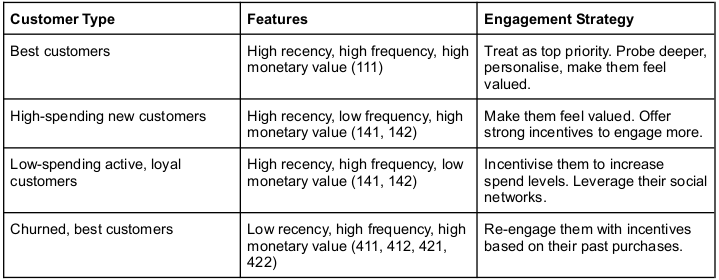  

We can generate lists for each customer segment, as shown below.

In [108]:
rfm[rfm['rfm']=='111'].sort_values('amount spent', ascending=False).head(10).style.set_caption('Best Customers')

Feature,days since last purchase,purchase frequency,amount spent,rfm
customer_id,,,,
14646.000000,1,2080,280206.020000,111
18102.000000,0,431,259657.300000,111
17450.000000,8,337,194550.790000,111
14911.000000,0,5677,143825.060000,111
14156.000000,9,1400,117379.630000,111
17511.000000,2,963,91062.380000,111
16684.000000,4,277,66653.560000,111
14096.000000,3,5111,65164.790000,111
13694.000000,3,568,65039.620000,111


In [109]:
rfm[(rfm['rfm']=='141') | (rfm['rfm']=='142')].sort_values('amount spent', ascending=False).head(10).style.set_caption('High Spending New Customers')

Feature,days since last purchase,purchase frequency,amount spent,rfm
customer_id,,,,
16446.000000,0,3,168472.500000,141
16000.000000,2,9,12393.700000,141
12798.000000,9,8,6977.040000,141
16532.000000,17,4,6748.800000,141
15195.000000,2,1,3861.000000,141
15473.000000,13,11,1771.200000,141
12882.000000,8,13,1463.040000,142
17856.000000,1,15,1418.030000,142
15621.000000,4,16,1293.030000,142


In [110]:
rfm[(rfm['rfm']=='113') | (rfm['rfm']=='114')].sort_values('amount spent', ascending=False).head(10).style.set_caption('Lowest Spending Active Loyal Customers')

Feature,days since last purchase,purchase frequency,amount spent,rfm
customer_id,,,,
17883.000000,2,145,671.770000,113
15031.000000,4,111,668.140000,113
16442.000000,1,174,616.790000,113
16005.000000,12,218,615.390000,113
14710.000000,14,139,606.130000,113
13558.000000,5,175,605.060000,113
14675.000000,16,102,604.750000,113
17864.000000,12,102,597.500000,113
17360.000000,17,132,585.790000,113


In [111]:
rfm[(rfm['rfm']=='411') | (rfm['rfm']=='412') | (rfm['rfm']=='421') | (rfm['rfm']=='422')].sort_values('amount spent', ascending=False).head(10).style.set_caption('Churned Best Customers')

Feature,days since last purchase,purchase frequency,amount spent,rfm
customer_id,,,,
12590.000000,211,68,9864.260000,421
13093.000000,275,159,7832.470000,411
16553.000000,162,84,5719.820000,421
17850.000000,371,297,5391.210000,411
15032.000000,255,52,4959.100000,421
14016.000000,161,161,4341.210000,411
15808.000000,306,208,3734.970000,411
15379.000000,169,194,3703.290000,411
17230.000000,263,69,3638.410000,421


## Conclusion  

We generated item recommendations for each customer above using multiple methods: rule-based, market basket analysis, NLP-based, and model-based. We can combine recommendations from each method to suggest a balanced set of items to each customer.  


**Future Analysis**  

We can probe deeper these aspects:  

1. Combine content-based, collaborative and model-based methods in hybrid modes to generate more balanced recommendations.
2. Hard-code some key attributes of items and customers to generate sharper, logical, and more relevant recommendations.
3. Use more recent word vectorization techniques and similarity measures to generate better recommendations.
4. Explore purchases within each customer segment (based on RFM metrics) to infer deeper purchase patterns.   

**References**  

https://neptune.ai/blog/vectorization-techniques-in-nlp-guide  
https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6  
https://www.optimove.com/resources/learning-center/rfm-segmentation  
https://tryolabs.com/blog/introduction-to-recommender-systems  